Let explain what we aim to solve broadly. In this analysis we divided into fundamental analysis and technical analysis.
- Fundamental analysis involve analyzing company's future profitability based on its current business environment and financial performance.
- Technical analysis on the the other hand includes reading the charts and using statistical figures to identify the trend in the stock market.

So our focus will be on the technical analysis part.

Dataset explanation:
- The Open and Close represent the starting and final price at which the stock is traded on a particular day.
- High, Low and Last represent the maximum, minimum, and last price of the share for the day.
- 
Another thing to consider is the trading opens at 9:00 a.m. and closes at 3:30 p.m (6hour30min). 
The market is open every day of the week except Saturday, Sunday, and holidays

The profit or loss calculation is usually determined by


 the closing price of ta stock for the day, so we will
use the 'close' (closing_price) as the target variable.

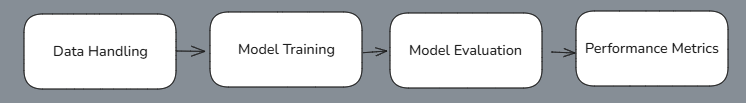

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('../data/korean_stock_data.csv')

In [4]:
# Rename columns
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Shares', 'Company', 'Date']
df.head(5)

,Open,High,Low,Close,Volume,Shares,Company,Date
0,10400.0,10920.0,10140.0,10880.0,114750.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-03
1,10720.0,10960.0,10480.0,10960.0,81165.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-04
2,10880.0,11120.0,10320.0,11120.0,66320.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-07
3,11120.0,11180.0,10940.0,11040.0,42455.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-08
4,10920.0,11060.0,10780.0,11060.0,43205.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-09


In [5]:
print(df.head())
print('\n Shape of the data:')
print(df.shape)

      Open     High      Low    Close    Volume   Shares  \
0  10400.0  10920.0  10140.0  10880.0  114750.0  5586294   
1  10720.0  10960.0  10480.0  10960.0   81165.0  5586294   
2  10880.0  11120.0  10320.0  11120.0   66320.0  5586294   
3  11120.0  11180.0  10940.0  11040.0   42455.0  5586294   
4  10920.0  11060.0  10780.0  11060.0   43205.0  5586294   

                 Company        Date  
0  Dongwha Pharm.Co.,Ltd  2008-01-03  
1  Dongwha Pharm.Co.,Ltd  2008-01-04  
2  Dongwha Pharm.Co.,Ltd  2008-01-07  
3  Dongwha Pharm.Co.,Ltd  2008-01-08  
4  Dongwha Pharm.Co.,Ltd  2008-01-09  

 Shape of the data:
(1048575, 8)


In [6]:
# setting the index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

df.head(1)

,Open,High,Low,Close,Volume,Shares,Company,Date
Date,,,,,,,,
2008-01-03,10400.0,10920.0,10140.0,10880.0,114750.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-03


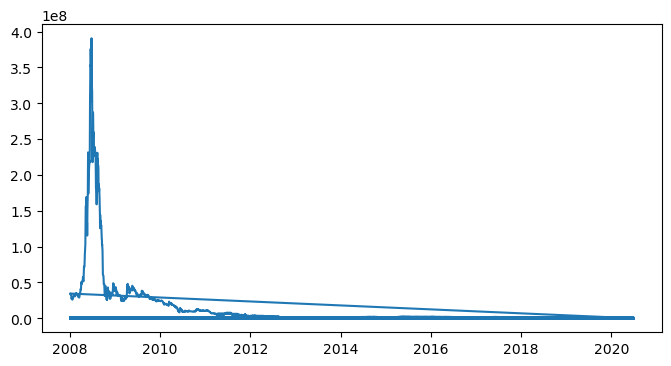

In [7]:
plt.figure(figsize=(8,4))
plt.plot(df['Close'], label="Close Price History")

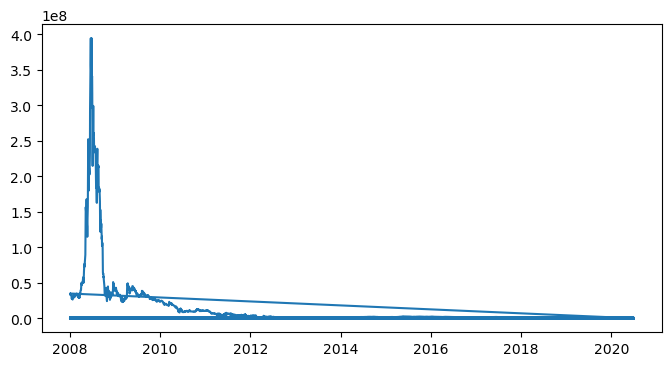

In [8]:
plt.figure(figsize=(8,4))
plt.plot(df['Open'], label="Open Price History")

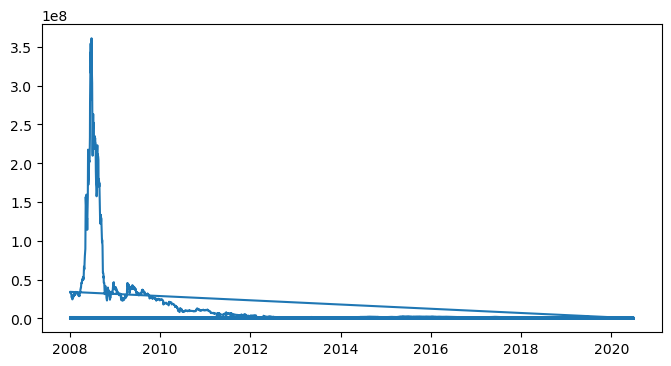

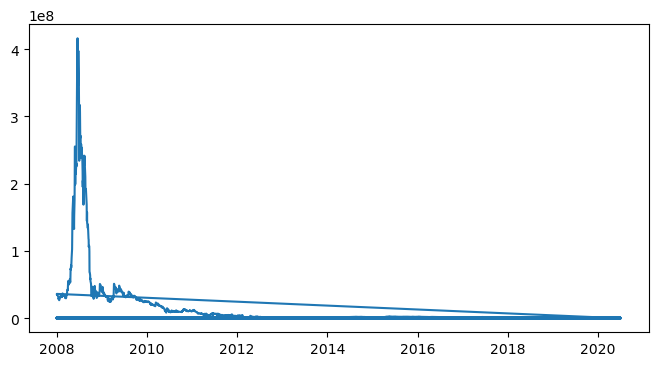

In [13]:
plt.figure(figsize=(8,4))
plt.plot(df['Low'], label="Low Price History")

plt.figure(figsize=(8,4))
plt.plot(df['High'], label="High Price History")

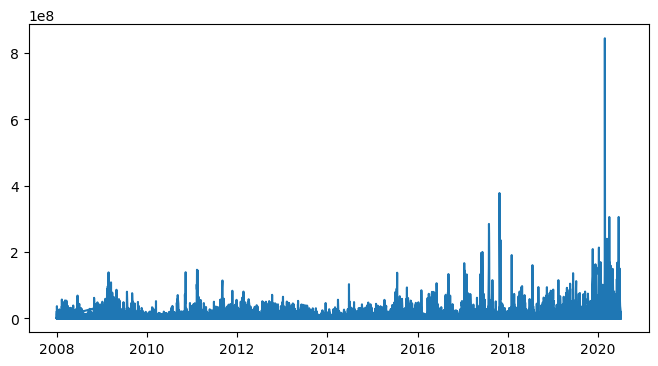

In [9]:
plt.figure(figsize=(8,4))
plt.plot(df['Volume'], label="Volume Price History")

Moving Average
We will try to determine overall performance 

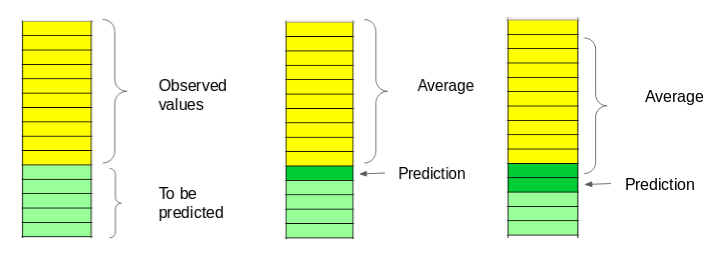 

### Step 1: Create a dataframe contain only 'close' and 'date' price columns, then split int inot train and val set to verify our predictions.

In [15]:
total_rows = len(df)

print(total_rows)
df.head(1)

1048575


,Open,High,Low,Close,Volume,Shares,Company,Date
Date,,,,,,,,
2008-01-03,10400.0,10920.0,10140.0,10880.0,114750.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-03


NOTE: While splitting the data into train and validation set, we cannot 
use random splitting since that will destroy the time component. So here we 
have set the last year’s data into validation and the 4 years’ data before that into train set.


Step-by-step process:
- Sort the data by date to ensure that it is in chronological order
- Determine the last year of data for the val set
- Split data val set (last year), train set (4y)


This mean that we chose not to split all data for training and validation due to the time-based split of the latest year of the data only. 


In [10]:
#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

In [12]:
new_data = df.copy() 
new_data = new_data.loc[~new_data.index.duplicated(keep='first')]

# Set the start date for validation (1 year before the latest date)
latest_date = new_data.index.max()
start_date_valid = latest_date - pd.DateOffset(years=1)

train_end_index = new_data.index[new_data.index < start_date_valid][-1]

train = new_data[:train_end_index]  
valid = new_data.loc[train_end_index + pd.Timedelta(days=1):]   

print('\nShape of training set:')
print(train.shape)

print('\nShape of validation set:')
print(valid.shape)


Shape of training set:
(2841, 8)

Shape of validation set:
(248, 8)


Let's check the RMSE whether it is align with the actual values in the val set.
What we are looking for:
- A lower RMSE mean better model performance so we are aiming for as low as possible
- In our case the RMSE is quite high

But first let's determine the look-back period of how much we should use to predict the next day
- Look-back window: 30-50Days


In [13]:
look_back = 30 

preds = []
for j in range(0, valid.shape[0]):
    a = train['Close'][len(train) - look_back + j:].sum() + sum(preds)
    b = a/look_back
    preds.append(b)

rms = np.sqrt(np.mean(np.power((np.array(valid['Close']) - preds), 2)))
print('\nRMSE value on validation set:')
print(rms)


RMSE value on validation set:
2979965.6456105947


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22952\1591430345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


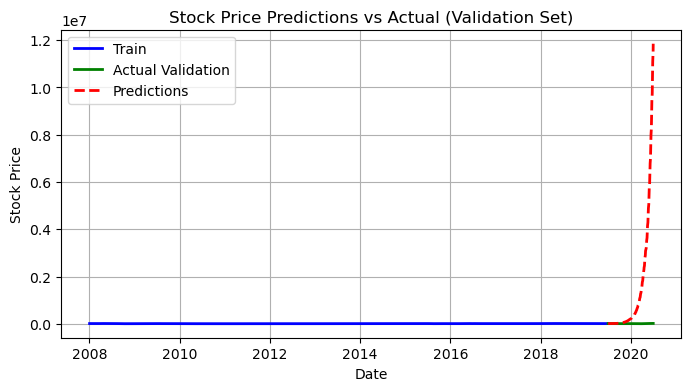

In [14]:
valid['Predictions'] = preds

plt.figure(figsize=(8,4)) 
plt.plot(train.index, train['Close'], label='Train', color='blue', linewidth=2)
plt.plot(valid.index, valid['Close'], label='Actual Validation', color='green', linewidth=2)
plt.plot(valid.index, valid['Predictions'], label='Predictions', color='red', linestyle='--', linewidth=2)

plt.title('Stock Price Predictions vs Actual (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Stock Price')

plt.legend()

plt.grid(True)
plt.show()

Implement a Linear Regression model to see the relationship between independent and dependent variables.

The code below wil create features such as:
- year
- month
- week
- day
- weekday
- is_month_end
- is_month_start
- is_quarter_end
- is_quarter_start
- is_year_end
- is_year_start

Additional feature shall be add accordingly. Such as the first the last day of the week could affect the stock's closing price far more than the other days. So, we wil create feature that identifies whether a given day is Monday/Friday, Tuesday/Wednesday/Thursday, and except weekend and holiday.

In [20]:
#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

In [21]:
# sorting
data = df.sort_index(ascending=True, axis=0)

In [22]:
df.head()

,Open,High,Low,Close,Volume,Shares,Company,Date
Date,,,,,,,,
2008-01-03,10400.0,10920.0,10140.0,10880.0,114750.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-03
2008-01-04,10720.0,10960.0,10480.0,10960.0,81165.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-04
2008-01-07,10880.0,11120.0,10320.0,11120.0,66320.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-07
2008-01-08,11120.0,11180.0,10940.0,11040.0,42455.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-08
2008-01-09,10920.0,11060.0,10780.0,11060.0,43205.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-09


In [23]:
# creatubg a separate dataset
new_data = pd.DataFrame({'Date': df.index, 'close': df['Close'].values})

new_data['year'] = new_data['Date'].dt.year
new_data['month'] = new_data['Date'].dt.month
new_data['day'] = new_data['Date'].dt.day
new_data['weekday'] = new_data['Date'].dt.weekday
new_data['is_month_end'] = new_data['Date'].dt.is_month_end
new_data['is_month_start'] = new_data['Date'].dt.is_month_start
new_data['is_quarter_end'] = new_data['Date'].dt.is_quarter_end
new_data['is_quarter_start'] = new_data['Date'].dt.is_quarter_start
new_data['is_year_end'] = new_data['Date'].dt.is_year_end
new_data['is_year_start'] = new_data['Date'].dt.is_year_start

new_data.drop('Date', axis=1, inplace=True)

if 'Elapsed' in new_data.columns:
    new_data.drop('Elapsed', axis=1, inplace=True)

new_data['mon_fri'] = new_data['weekday'].apply(lambda x: 1 if x == 0 or x == 4 else 0)
# NOTE: if the day of the week is equal to 0 or 4, the col value will be 1; otherwise, it will be 0 

In [24]:
print(f"train_end_index: {train_end_index}")
print(f"Index in DataFrame: {new_data.index}")

train_end_index: 2019-06-28 00:00:00
Index in DataFrame: RangeIndex(start=0, stop=1048575, step=1)


In [25]:
df.head()

,Open,High,Low,Close,Volume,Shares,Company,Date
Date,,,,,,,,
2008-01-03,10400.0,10920.0,10140.0,10880.0,114750.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-03
2008-01-04,10720.0,10960.0,10480.0,10960.0,81165.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-04
2008-01-07,10880.0,11120.0,10320.0,11120.0,66320.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-07
2008-01-08,11120.0,11180.0,10940.0,11040.0,42455.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-08
2008-01-09,10920.0,11060.0,10780.0,11060.0,43205.0,5586294,"Dongwha Pharm.Co.,Ltd",2008-01-09


In [26]:
# checking the col name before droping off 'close'
new_data.columns

Index(['close', 'year', 'month', 'day', 'weekday', 'is_month_end',
       'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_year_end',
       'is_year_start', 'mon_fri'],
      dtype='object')

In [27]:
print(new_data.columns)

if 'Date' not in new_data.columns:
    new_data['Date'] = pd.to_datetime(new_data['year'].astype(str) + '-' + 
                                       new_data['month'].astype(str) + '-' + new_data['day'].astype(str), 
                                       errors='coerce')
new_data.set_index('Date', inplace=True)

print(new_data.index[:10]) 


Index(['close', 'year', 'month', 'day', 'weekday', 'is_month_end',
       'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_year_end',
       'is_year_start', 'mon_fri'],
      dtype='object')
DatetimeIndex(['2008-01-03', '2008-01-04', '2008-01-07', '2008-01-08',
               '2008-01-09', '2008-01-10', '2008-01-11', '2008-01-14',
               '2008-01-15', '2008-01-16'],
              dtype='datetime64[ns]', name='Date', freq=None)


 NOTE: While splitting the data into train and validation set, we cannot use random splitting since that will destroy the time component. So here we have set the last year’s data into validation and the 4 years’ data before that into train set.

In [28]:
# check the year range 
year_range = new_data.index.min(), new_data.index.year.max()
year_range

(Timestamp('2008-01-03 00:00:00'), 2020)

In [29]:
# Training Period: From 2008-01-03 to 2016-12-31 (8 years).
# Validation Period: From 2017-01-01 to 2020-12-31 (4 years).
train_start_date = '2008-01-03'
train_end_date = '2016-12-31'
valid_start_date = '2017-01-01'
valid_end_date = '2020-12-31'

#convert string to datetime
train_start_date = pd.to_datetime(train_start_date)
train_end_date = pd.to_datetime(train_end_date)
valid_start_date = pd.to_datetime(valid_start_date)
valid_end_date = pd.to_datetime(valid_end_date)

#split
train = new_data[(new_data.index >= train_start_date) & (new_data.index <= train_end_date)]
valid = new_data[(new_data.index >= valid_start_date) & (new_data.index <= valid_end_date)]

print(f"Shape of training set: {train.shape}")
print(f"Shape of validation set: {valid.shape}")

Shape of training set: (780154, 12)
Shape of validation set: (268421, 12)


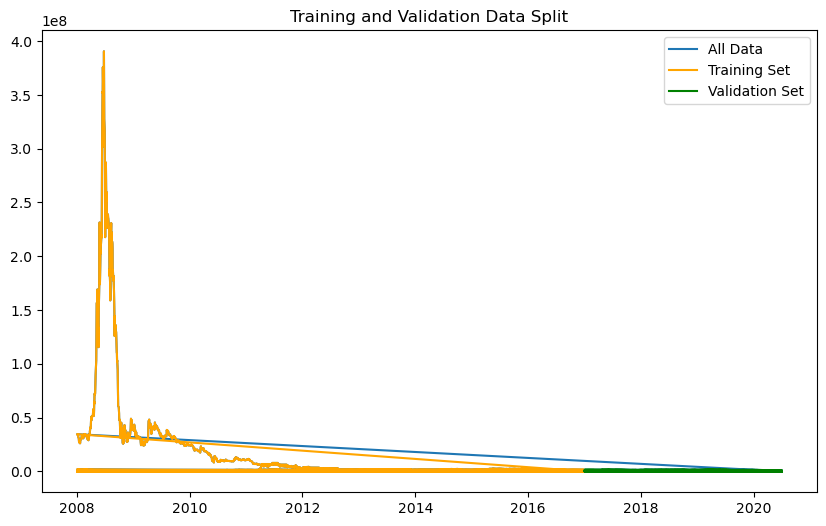

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(new_data.index, new_data['close'], label='All Data')
plt.plot(train.index, train['close'], label='Training Set', color='orange')
plt.plot(valid.index, valid['close'], label='Validation Set', color='green')
plt.legend()
plt.title('Training and Validation Data Split')
plt.show()

Observation:
- All data: we split data from 2008 to 2020, however we could see there is a significant rise in the data up to around 2010, followed by a sharp drop and more like leveling off afterwards. We could assume there might be a fluctuation in the data, this could possibly due to the market events such as crisis or anomalies.
- Train set: we split data from 2008 to the point where the val set starts.
- Validation set: this covers the more recent period of the data from 2017 to 2020 


Potentail concerns:
- Market changes (structural breaks): one thing to consider is whether the market or underlying processes have significantly changed between the training and validation period. For example,
during the COVID-19 pandemic which might occur during the validation period could introduce a new patterns that the data does not capture well which lead to the high fluctuation.

Solution;
- Ensure similar conditions: if there are drastic changes between the two periods (pre- and post- 2016) we can consider using a more recent data int the training set to better reflect the current market conditions
- Use rolling window method: fro training and validation splits, where the model is trained on more recent data and tested on the subsequent period to reflect hwo the model might perform in real-time forecasting
- Experiment with different splits: Use 3y for training (2015-2018), 1y for validation(2019), or 5y 2008-2018 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27636\385346943.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


RMSE value on validation set: nan


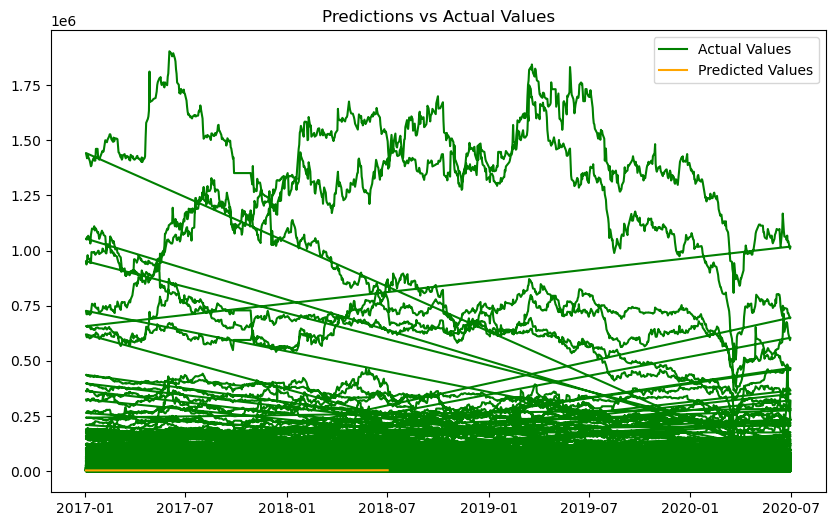

In [31]:
look_back = 365  # 1 year preds

preds = []

for i in range(0, valid.shape[0]):
    #using rolling mean instead of sum to avoid overflow
    a = train['close'][len(train) - look_back + i:].mean()  # Mean over the last 365 days
    preds.append(a)

valid['Predictions'] = preds

rms = np.sqrt(np.mean(np.power((np.array(valid['close']) - np.array(preds)), 2)))
print("RMSE value on validation set:", rms)

plt.figure(figsize=(10, 6))
plt.plot(valid.index, valid['close'], label='Actual Values', color='green')
plt.plot(valid.index, valid['Predictions'], label='Predicted Values', color='orange')
plt.legend()
plt.title('Predictions vs Actual Values')
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27636\2988067003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27636\2988067003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


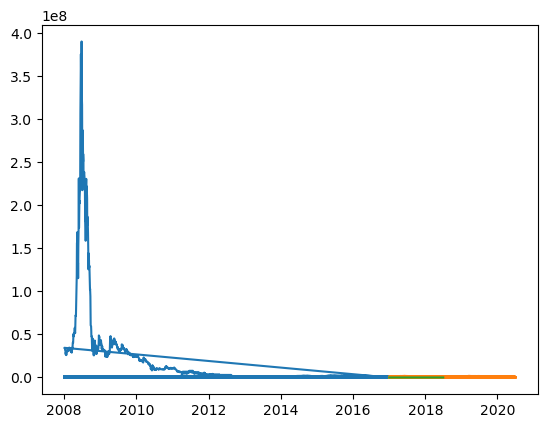

In [32]:
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

x_train = train.drop('close', axis=1)  
y_train = train['close']  
x_valid = valid.drop('close', axis=1)  
y_valid = valid['close'] 

x_valid = x_valid.loc[:, x_train.columns]  

model = LinearRegression()
model.fit(x_train, y_train)

preds = model.predict(x_valid)

rms = np.sqrt(mean_squared_error(y_valid, preds))
print("RMSE value on validation set:", rms)

RMSE value on validation set: 172304.48865219188


In [1]:
valid['Predictions'] = preds

plt.figure(figsize=(12, 6))
plt.plot(valid.index, valid['close'], color='green')
plt.plot(valid.index, valid['Predictions'],color='orange')
plt.title('Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

NameError: name 'preds' is not defined

# Inference 

The problem we are facing is the regression algorithm can overfits the data and month column. So instead of taking into account the previous values from the point of prediction. The model will consider the value from the same date a month ago or the saem date/month a year ago. Therefore, in here we are looking for the independent variables that could be useful for determining the target value.

To find the potential target variable we will introduce the KNN algorithm.

In [35]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['close']])
valid_scaled = scaler.transform(valid[['close']]) 

In [37]:
# we will use the same train and validation set from last section
# scaling data 
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

# using gridsearch to find the best parameter 
params = {'n_neighbors' :[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

# fit the model and make preds
model.fit(x_train, y_train)
preds= model.predict(x_valid)

In [39]:
rms = np.sqrt(np.mean(np.square(np.array(y_valid) - np.array(preds))))
print(f"RMSE: {rms}")

RMSE: 3929451.6523326007


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21868\3416686372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21868\3416686372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


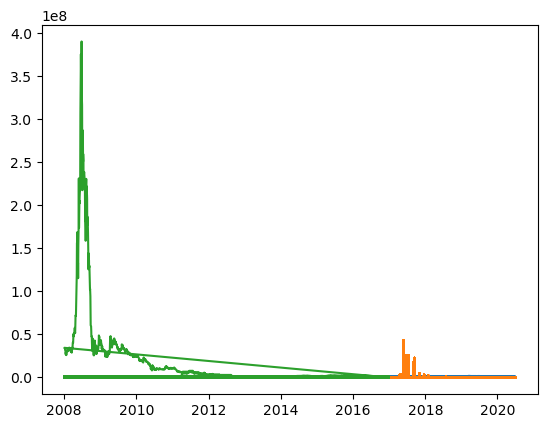

In [90]:
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['close', 'Predictions']])
plt.plot(train['close'])

Auto ARIMA is a statistical method for time seriees forecasting, it takes into account the past values to predict the future values. There are three important paarameters in ARIMA:
- p : past value used for forecasting the next level
- q : past forecast errors used to predict the future values
- d : order of differencing

Ref:
- [Understand ARIMA](https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp)
- [ARIMA for Time Series Forecasting: A Complete Guide](https://www.datacamp.com/tutorial/arima?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720824&utm_adgroupid=157156375671&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=684592140413&utm_targetid=aud-1940143831083:dsa-2218886984580&utm_loc_interest_ms=&utm_loc_physical_ms=1030757&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-apac_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na&gad_source=1&gclid=CjwKCAiAzba9BhBhEiwA7glbagRjFymdE4FNEQY5fA4CFyFXky2KgSmtud644MPkQieci9IoSOB7OhoCwiYQAvD_BwE)
- [Build high performance Time Series Models using Auto ARIMA in python and R](https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/)

In [40]:
from pmdarima import auto_arima 

#sorting
data = df.sort_index(ascending=True, axis=0)

# split the data into train and val sets based on 'train_end_index' date
train = data.loc['2010-01-01':'2015-12-31']
valid = data[data.index > train_end_index]

training = train['Close']
validation = valid['Close'] 

# fit the arima model 
model = auto_arima(training, start_p=1, start_q=1, max_p=2, max_q=2, m=12, seasonal=True, d=1, D=1, trace=True)

# model = auto_arima(training, start_p=1, start_q=1, max_p=3, max_q=3, m=12, 
#                    start_P=0, seasonal=True, d=1, D=1, trace=True, 
#                    error_action='ignore', suppress_warnings=True)
model.fit(training)

# predict on the val set
forecast = model.predict(n_periods=len(validation))

# convert the forecast into a DataFrame to align with the validation dates
forecast = pd.DataFrame(forecast, index=valid.index, columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1039.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=15501340.206, Time=49.96 sec


MemoryError: Unable to allocate 3.94 MiB for an array with shape (1, 516204) and data type float64

In [ ]:
rms = np.sqrt(mean_squared_error(validation, forecast))
print(f"RMSE on validation set: {rms}")

plt.plot(validation.index, validation.values, label='Actual')
plt.plot(validation.index, forecast, label='Predicted', color='orange')
plt.legend()
plt.show()

Observation:
- The auto ARIMA uses past data to understand the pattern in the time series. Using these values, the model captured an increasing trend in the series. Although the stock market predictions using thi machine learning are far better than those of the previously implemented machin learning models, theses predictions are still not close to the real values. 

As the plot shows, the model has captured a trend in the seire but does not focus on the seasonality. We will implement the a time series model that takes both trend and seasonality into account. 

Several time series technique can be implemented on the stock prediction machine learning dataset. but most of these techniques require extensive data preprocessing before fitting the model. Prophet, designed and pioneered by Facebook, is a time series forecasting library that requires no data preprocessing and is extremely simple to implement. The input for Prophet is a dataframes with two columns: date and target (ds and y) 

Prophet tries to capture the seasonality in the past data and works well when the dataset is large.   

Ref:
- [Generate Quick and Accurate Time Series Forecasts using Facebook’s Prophet (with Python & R codes)](https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/)

In [ ]:
from fbprophet import Prophet

# creating new dataframe
new_data = pd.DataFrame(index=range(0, len(df)), columns=['date', 'close'])

for j in range(0, len(data)):
    new_data['date'][j] = data['date'][j]
    new_data

ModuleNotFoundError: No module named 'fbprophet'

Feature Engineering 
- Latest Announcement of companies
- Quarterly Revenue Results
- Total Trade Quantity is the number of shares bought or sold in the day and Turnover (lacs) is the turn over of the particular company on a given date